In [81]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py
import rasterio
import numpy as np
from rasterio.plot import show, show_hist
from scipy.stats import linregress, describe, rv_histogram

## 2nd level heading

In [2]:
#load the excel data
df = pd.read_excel('field_observation.xls')
point_data = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))
point_data.set_crs(epsg=32644, inplace=True)

,Plot,X,Y,nnx,nny,canopy density (%),light intensity,geometry
0,0,548171,3057513,273.033333,416.966667,0.0,18.40,POINT (548171.000 3057513.000)
1,1,547415,3052674,247.833333,578.266667,81.0,2.20,POINT (547415.000 3052674.000)
2,2,547177,3052725,239.900000,576.566667,46.0,11.80,POINT (547177.000 3052725.000)
3,3,546887,3052673,230.233333,578.300000,84.8,1.90,POINT (546887.000 3052673.000)
4,4,546619,3052552,221.300000,582.333333,79.0,2.30,POINT (546619.000 3052552.000)
...,...,...,...,...,...,...,...,...
367,367,549780,3065424,326.666667,153.266667,76.0,4.27,POINT (549780.000 3065424.000)
368,368,550326,3065855,344.866667,138.900000,81.0,1.60,POINT (550326.000 3065855.000)
369,369,549604,3065668,320.800000,145.133333,81.0,3.60,POINT (549604.000 3065668.000)
370,370,548628,3065963,288.266667,135.300000,75.1,2.87,POINT (548628.000 3065963.000)


In [3]:
# use GDAL to extract required bands (and convert to tif)
!gdal_translate np_20011024_refl.img -b 4 -b 5 -b 3 np_20011024_refl.tif

Input file size is 400, 834
0...10...20...30...40...50...60...70...80...90...100 - done.


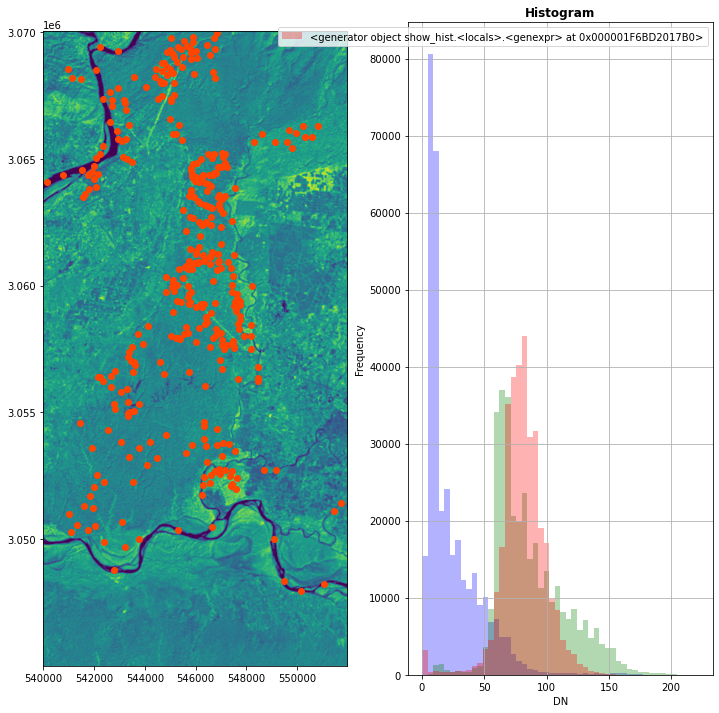

In [4]:
# load Raster data
s = rasterio.open('np_20011024_refl.tif')
fig, (ax, axhist) = plt.subplots(1, 2, figsize=(12,12))
point_data.plot(ax=ax, color='orangered')
show(s, ax=ax)
show_hist(s, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

In [79]:
# extract raster values at points using rasterio .sample()
coords = [(x,y) for x, y in zip(point_data.X, point_data.Y)]
point_data['Raster Value'] = [x for x in s.sample(coords)]

# calculate NDVI
point_data['NDVI'] = (point_data['Raster Value'].str[0] - point_data['Raster Value'].str[2]) / (point_data['Raster Value'].str[0] + point_data['Raster Value'].str[2])

# calculate SR
point_data['SR'] = point_data['Raster Value'].str[0]/point_data['Raster Value'].str[2]

# a look at the dataframe with extracted DNs, calculated NDVI ans SR indices values
point_data.head()

,Plot,X,Y,nnx,nny,canopy density (%),light intensity,geometry,Raster Value,NDVI,SR
0,0,548171,3057513,273.033333,416.966667,0.0,18.4,POINT (548171.000 3057513.000),"[145, 152, 38]",0.584699,3.815789
1,1,547415,3052674,247.833333,578.266667,81.0,2.2,POINT (547415.000 3052674.000),"[128, 90, 3]",0.954198,42.666667
2,2,547177,3052725,239.900000,576.566667,46.0,11.8,POINT (547177.000 3052725.000),"[93, 76, 5]",0.897959,18.600000
3,3,546887,3052673,230.233333,578.300000,84.8,1.9,POINT (546887.000 3052673.000),"[132, 88, 8]",0.885714,16.500000
4,4,546619,3052552,221.300000,582.333333,79.0,2.3,POINT (546619.000 3052552.000),"[117, 82, 8]",0.872000,14.625000


In [9]:
# one or mopre of the SR values gave and error giving an infinity value
point_data['SR'].describe()

count    372.000000
mean            inf
std             NaN
min        0.000000
25%        4.826923
50%        8.286364
75%       11.500000
max             inf
Name: SR, dtype: float64

In [10]:
#replace this inf value to a Nan value
point_data['SR'].replace(np.inf, np.nan, inplace=True)

In [11]:
#calculate correlation coefficients

canopy_band4 = point_data['canopy density (%)'].corr(point_data['Raster Value'].str[0])
canopy_band5 = point_data['canopy density (%)'].corr(point_data['Raster Value'].str[1])
canopy_band3 = point_data['canopy density (%)'].corr(point_data['Raster Value'].str[2])
canopy_NDVI = point_data['canopy density (%)'].corr(point_data['NDVI'])
canopy_SR = point_data['canopy density (%)'].corr(point_data['SR'])

light_band4 = point_data['light intensity'].corr(point_data['Raster Value'].str[0])
light_band5 = point_data['light intensity'].corr(point_data['Raster Value'].str[1])
light_band3 = point_data['light intensity'].corr(point_data['Raster Value'].str[2])
light_NDVI = point_data['light intensity'].corr(point_data['NDVI'])
light_SR = point_data['light intensity'].corr(point_data['SR'])

In [12]:
# add coefficients to a dic and convert to df to easy reading

corr_dict = {'biological attributes': ['canopy density (%)', 'light intensity'],
            'Band 4': [canopy_band4, light_band4],
            'Band 5': [canopy_band5, light_band5],
            'Band 3': [canopy_band3, light_band3],
            'NDVI': [canopy_NDVI, light_NDVI],
            'SR': [canopy_SR, light_SR]}

corr_df = pd.DataFrame(corr_dict)
corr_df = corr_df.transpose()
corr_df

,0,1
biological attributes,canopy density (%),light intensity
Band 4,0.320603,-0.323536
Band 5,-0.216024,0.206974
Band 3,-0.53462,0.525831
NDVI,0.53777,-0.533861
SR,0.608042,-0.594625


In [13]:
# calculate the correlation between canopy attributes
point_data['canopy density (%)'].corr(point_data['light intensity'])

-0.9886624290330429

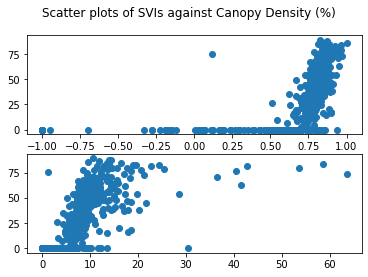

In [85]:
fig, (ax1, ax2) = plt.subplots(2, sharey=True)
fig.suptitle("Scatter plots of SVIs against Canopy Density (%)")
ax1.scatter(x=point_data['NDVI'], y=point_data['canopy density (%)'])
ax2.scatter(x=point_data['SR'], y=point_data['canopy density (%)'])

In [84]:
# plot SVI values against Canopy Density (%)
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('NDVI','SR'))
fig.add_trace(
    go.Scatter(x=point_data['NDVI'], y=point_data['canopy density (%)'], mode='markers'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=point_data['SR'], y=point_data['canopy density (%)'], mode='markers'),
    row=1, acol=2
)
fig.update_layout(title_text="Scatter plots of SVIs against Canopy Density (%)",
                  showlegend=False
)

py.iplot(fig)

In [16]:
# remove 0 values and the outlier in NDVI
point_data_new = point_data[(point_data['canopy density (%)'] > 0.0) & (point_data['NDVI'] > 0.5)].copy()

In [20]:
# recalculate correlation coefficients
canopy_band4 = point_data_new['canopy density (%)'].corr(point_data_new['Raster Value'].str[0])
canopy_band5 = point_data_new['canopy density (%)'].corr(point_data_new['Raster Value'].str[1])
canopy_band3 = point_data_new['canopy density (%)'].corr(point_data_new['Raster Value'].str[2])
canopy_NDVI = point_data_new['canopy density (%)'].corr(point_data_new['NDVI'])
canopy_SR = point_data_new['canopy density (%)'].corr(point_data_new['SR'])

light_band4 = point_data_new['light intensity'].corr(point_data_new['Raster Value'].str[0])
light_band5 = point_data_new['light intensity'].corr(point_data_new['Raster Value'].str[1])
light_band3 = point_data_new['light intensity'].corr(point_data_new['Raster Value'].str[2])
light_NDVI = point_data_new['light intensity'].corr(point_data_new['NDVI'])
light_SR = point_data_new['light intensity'].corr(point_data_new['SR'])

In [21]:
# and update the dictionary and dataframe
corr_dict = {'biological attributes': ['canopy density (%)', 'light intensity'],
            'Band 4': [canopy_band4, light_band4],
            'Band 5': [canopy_band5, light_band5],
            'Band 3': [canopy_band3, light_band3],
            'NDVI': [canopy_NDVI, light_NDVI],
            'SR': [canopy_SR, light_SR]}

corr_df = pd.DataFrame(corr_dict)
corr_df = corr_df.transpose()
corr_df

,0,1
biological attributes,canopy density (%),light intensity
Band 4,0.326074,-0.30899
Band 5,-0.282964,0.286562
Band 3,-0.560606,0.533888
NDVI,0.617229,-0.588258
SR,0.458158,-0.431034


In [76]:
# plot SVI values against Canopy Density (%)
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('NDVI','SR'))
fig.add_trace(
    go.Scatter(x=point_data_new['NDVI'], y=point_data_new['canopy density (%)'], mode='markers'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=point_data_new['SR'], y=point_data_new['canopy density (%)'], mode='markers'),
    row=1, col=2
)
fig.update_layout(title_text="Scatter plots of SVIs against Canopy Density (%)  ",
                  showlegend=False
)

py.iplot(fig)

In [23]:
# now to create the rasters for the SVIs 

# Set bands for generating raster
red = s.read(3).astype(float)
nir = s.read(1).astype(float)
np.seterr(divide='ignore', invalid='ignore')  # ignore division errors

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

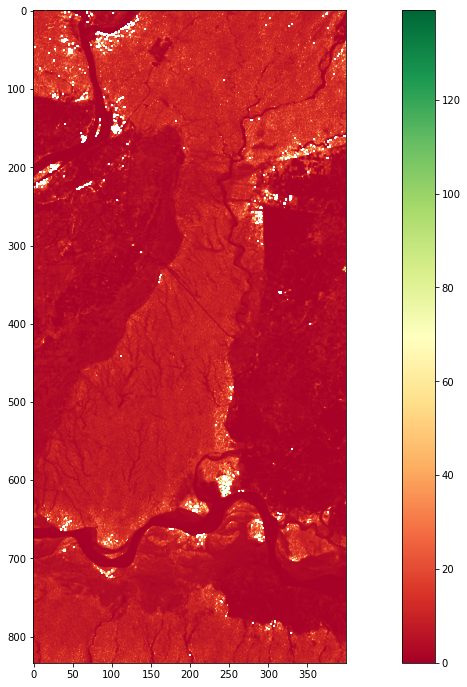

In [24]:
# calculate SR for raster
SR = nir/red

# and plot SR raster layer
plt.figure(figsize = (20,12))
plt.imshow(SR, cmap="RdYlGn")
plt.colorbar()
plt.show()

<AxesSubplot:>

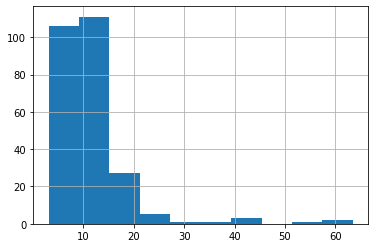

In [25]:
#the distribution doesnt look right, maybe some errornous value at the top end ...
point_data_new['SR'].hist() # look at the histogram of the point data

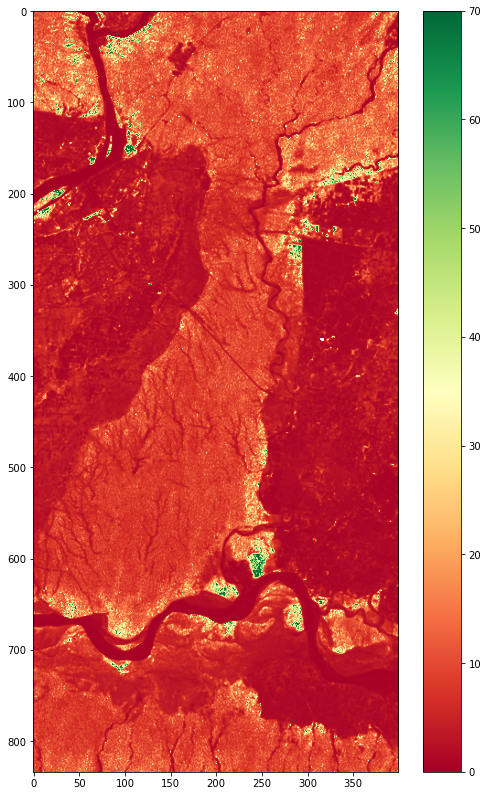

In [59]:
# replot with clipped outliers
plt.figure(figsize = (9,14))
plt.imshow(np.clip(SR, 0, 70), cmap="RdYlGn")
plt.colorbar()
plt.show()

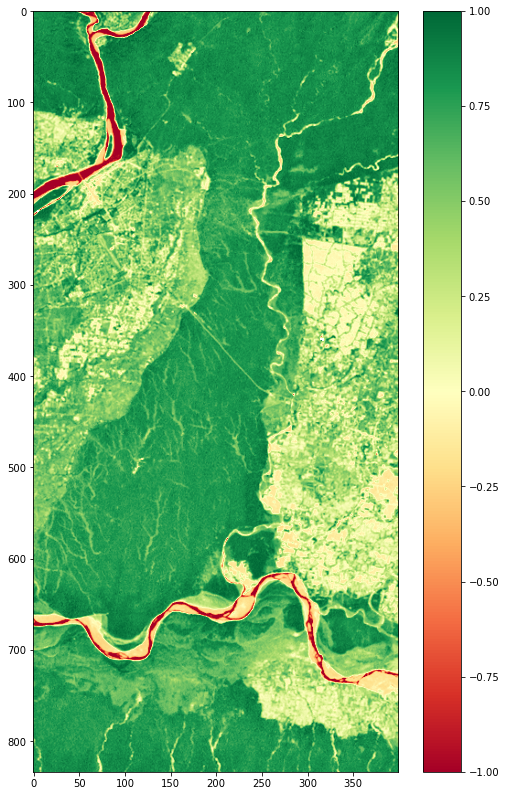

In [58]:
# calculate NDVI for raster
NDVI = (nir-red)/(nir+red)

# and plot NDVI raster layer
plt.figure(figsize = (9,14))
plt.imshow(NDVI, cmap="RdYlGn")
plt.colorbar()
plt.show()

(array([[ 12.,   0.,   5., ..., 224., 275., 185.],
        [ 13.,   3.,   2., ..., 219., 271., 193.],
        [ 15.,   0.,   1., ..., 219., 301., 191.],
        ...,
        [  1.,   0.,   3., ..., 153.,  99., 167.],
        [  1.,   1.,   1., ..., 173.,  91., 172.],
        [  1.,   1.,   0., ..., 162.,  92., 180.]]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 400 BarContainer objects>)

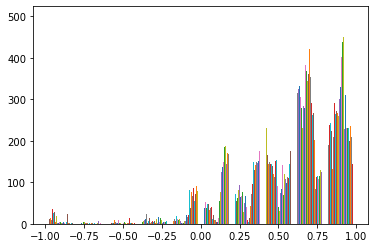

In [28]:
#plot a histogram of the NDVI values
plt.hist(NDVI)

In [29]:
#calculate regression stats for NDVI and Canopy Density (%)
reg = linregress(point_data_new['NDVI'],point_data_new['canopy density (%)'])
print(reg)

LinregressResult(slope=186.65945760658215, intercept=-103.7461581835557, rvalue=0.6172289374610263, pvalue=1.7507047946226463e-28, stderr=14.870961139036076, intercept_stderr=12.089842416897852)


In [30]:
# build regression equation  
print(f'regression equation is: {reg.intercept} + ({reg.slope} * NDVI)')

regression equation is: -103.7461581835557 + (186.65945760658215 * NDVI)


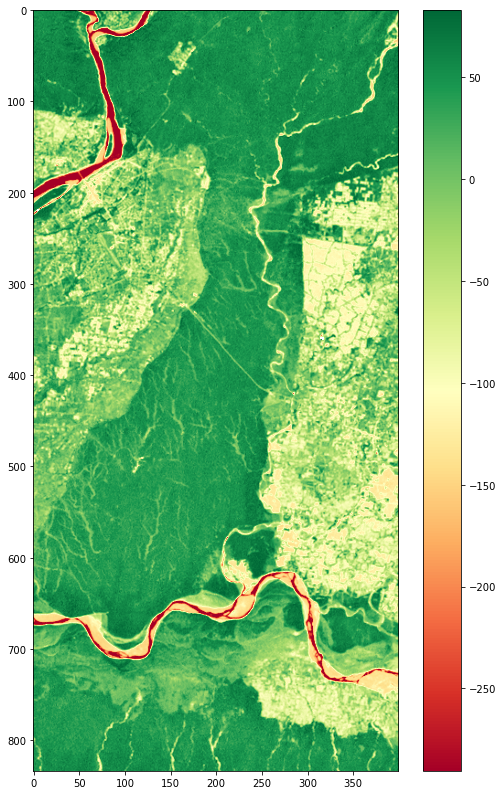

In [77]:
# define the function to apply equation to NDVI raster
def NDVI2CD(NDVI):
    return reg.intercept + (reg.slope * NDVI)

# plot the raster with applied function
plt.figure(figsize = (9,14))
plt.imshow(NDVI2CD(NDVI), cmap="RdYlGn")
plt.colorbar()
plt.show()

(array([[ 12.,   0.,   5., ..., 227., 278., 185.],
        [ 13.,   3.,   2., ..., 217., 274., 193.],
        [ 15.,   0.,   1., ..., 215., 305., 191.],
        ...,
        [  1.,   0.,   3., ..., 152., 101., 167.],
        [  1.,   1.,   1., ..., 169.,  96., 172.],
        [  1.,   1.,   0., ..., 159.,  95., 180.]]),
 array([-290.40561579, -253.07372427, -215.74183275, -178.40994123,
        -141.0780497 , -103.74615818,  -66.41426666,  -29.08237514,
           8.24951638,   45.5814079 ,   82.91329942]),
 <a list of 400 BarContainer objects>)

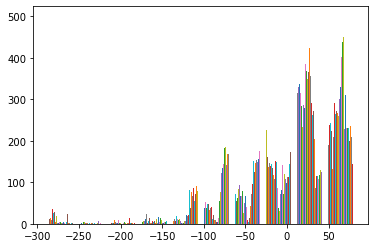

In [37]:
plt.hist(NDVI2CD(NDVI))

In [31]:
point_data_new['est_cd%'] = reg.intercept + (reg.slope * point_data_new['NDVI'])

In [38]:
point_data_new.head()

,Plot,X,Y,nnx,nny,canopy density (%),light intensity,geometry,Raster Value,NDVI,SR,est_cd%
1,1,547415,3052674,247.833333,578.266667,81.0,2.2,POINT (547415.000 3052674.000),"[128, 90, 3]",0.954198,42.666667,74.364011
2,2,547177,3052725,239.900000,576.566667,46.0,11.8,POINT (547177.000 3052725.000),"[93, 76, 5]",0.897959,18.600000,63.866416
3,3,546887,3052673,230.233333,578.300000,84.8,1.9,POINT (546887.000 3052673.000),"[132, 88, 8]",0.885714,16.500000,61.580790
4,4,546619,3052552,221.300000,582.333333,79.0,2.3,POINT (546619.000 3052552.000),"[117, 82, 8]",0.872000,14.625000,59.020889
5,5,546573,3052201,219.766667,594.033333,47.6,10.0,POINT (546573.000 3052201.000),"[111, 88, 8]",0.865546,13.875000,57.816229


<AxesSubplot:>

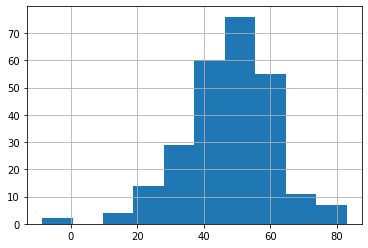

In [33]:
point_data_new['est_cd%'].hist()

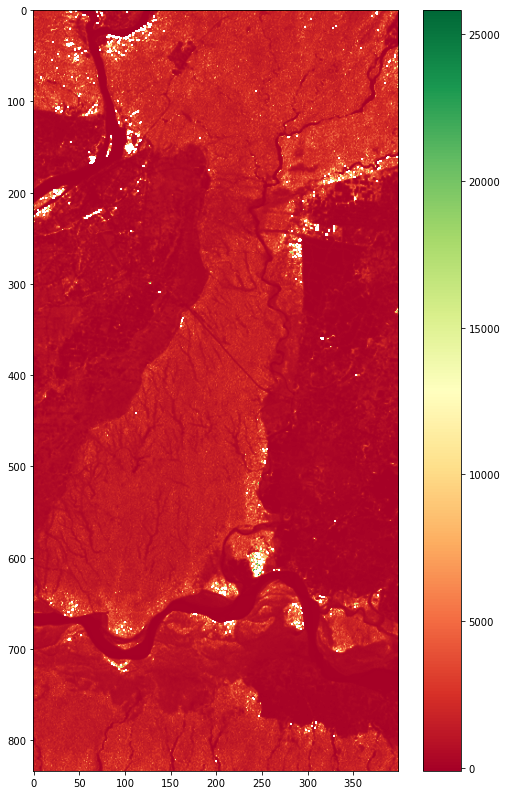

In [78]:
# define the function to apply equation to SR raster
def SR2CD(SR):
    return reg.intercept + (reg.slope * SR)

# plot the raster with applied function
plt.figure(figsize = (9,14))
plt.imshow(SR2CD(SR), cmap="RdYlGn")
plt.colorbar()
plt.show()